###### Dataset : https://fred.stlouisfed.org/series/IPN31152N
###### FROZEN DESSERT DATATSET

In [41]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [42]:
df = pd.read_csv('Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)

In [43]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [44]:
df.columns = ['Production']

In [45]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


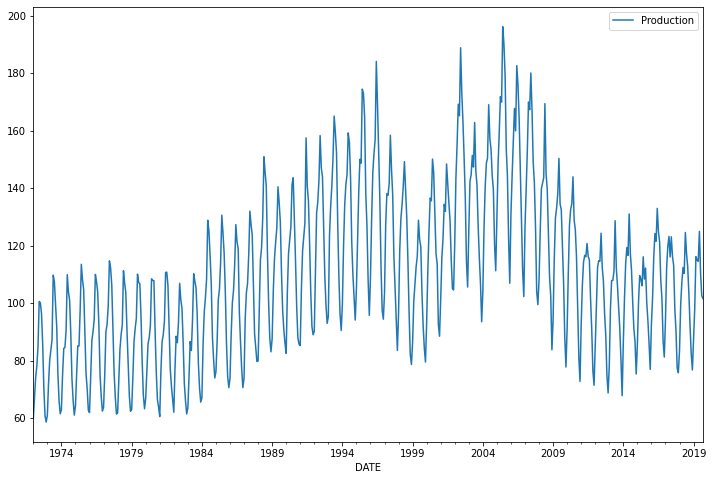

In [46]:
df.plot(figsize=(12,8))

## Train Test Split

In [47]:
len(df)

573

In [48]:
test_size = 18
test_ind = len(df)- test_size

In [49]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [50]:
len(test)

18

In [51]:
from sklearn.preprocessing import MinMaxScaler

In [52]:
scaler = MinMaxScaler()

In [53]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler()

In [54]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [55]:
#CODE HERE

In [56]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [57]:
length = 12
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [59]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [61]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [62]:
from tensorflow.keras.callbacks import EarlyStopping

In [63]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [64]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 543 steps, validate for 6 steps
Epoch 1/20
543/543 [==============================] - 5s 10ms/step - loss: 0.0218 - val_loss: 0.0046
Epoch 2/20
543/543 [==============================] - 3s 6ms/step - loss: 0.0071 - val_loss: 0.0025
Epoch 3/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0059 - val_loss: 0.0026
Epoch 4/20
543/543 [==============================] - 3s 6ms/step - loss: 0.0043 - val_loss: 0.0026


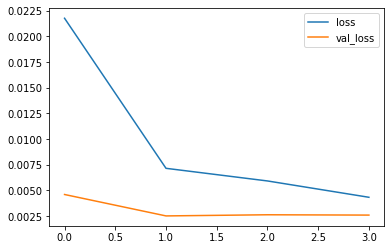

In [65]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [66]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [67]:
true_predictions = scaler.inverse_transform(test_predictions)

In [68]:
test['Predictions'] = true_predictions

C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [69]:
test

,Production,Predictions
DATE,,
2018-04-01,112.4309,118.692275
2018-05-01,110.3544,122.611379
2018-06-01,124.5841,125.049360
2018-07-01,117.2215,122.354772
2018-08-01,112.6779,115.122303
2018-09-01,103.3118,103.120823
2018-10-01,92.1321,92.786254
2018-11-01,82.4347,83.588517
2018-12-01,76.7608,81.853319


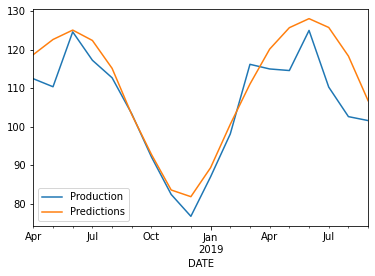

In [70]:
test.plot()

In [71]:
from sklearn.metrics import mean_squared_error

In [72]:
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

7.298868017859216